In [3]:
import numpy as np , pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import  (LinearRegression , LogisticRegression , Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import  (train_test_split , GridSearchCV)
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError , R2Score)
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.utilities.seed import seed_everything
from torchvision.datasets import MNIST , CIFAR100
from torchvision.models import (resnet50 , ResNet50_Weights)
from torchvision.transforms import (Resize , Normalize , CenterCrop , ToTensor)
from ISLP.torch import (SimpleDataModule , SimpleModule ,ErrorTracker , rec_num_workers)
from glob import glob
import json

seed_everything (0, workers=True)
torch.use_deterministic_algorithms(True , warn_only=True)

Global seed set to 0


Single Layer Network on Hitters Data

In [8]:
Hitters = load_data("Hitters").dropna()
n = Hitters.shape [0]

model = MS(Hitters.columns.drop("Salary"), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters["Salary"]. to_numpy()

(X_train , X_test , Y_train , Y_test) = train_test_split(X, Y, test_size =1/3,random_state =1)

hit_lm = LinearRegression ().fit(X_train , Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.7152883314629

In [13]:
scaler = StandardScaler(with_mean=True , with_std=True)
lasso = Lasso(warm_start=True , max_iter =30000)
standard_lasso = Pipeline(steps =[("scaler", scaler), ("lasso", lasso)])

X_s = scaler.fit_transform(X_train)
n = X_s.shape [0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean ())). max() / n
param_grid = {"alpha": np.exp(np.linspace (0, np.log (0.01) , 100))* lam_max}

cv = KFold (10, shuffle=True, random_state =1)
grid = GridSearchCV(lasso, param_grid , cv=cv , scoring="neg_mean_absolute_error")
grid.fit(X_train , Y_train);

trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.2382010799507

In [16]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel, self).__init__ ()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(nn.Linear(input_size, 50), nn.ReLU(), nn.Dropout (0.4), nn.Linear (50, 1))
    def forward(self , x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))
    
hit_model = HittersModel(X.shape [1])

summary(hit_model, input_size=X_train.shape , col_names =["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [20]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t , Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t , Y_test_t)

max_num_workers = rec_num_workers ()

hit_dm = SimpleDataModule(hit_train, hit_test, batch_size =32, num_workers=min(4, max_num_workers), validation=hit_test)

hit_module = SimpleModule.regression(hit_model, metrics ={"mae":MeanAbsoluteError ()})

hit_logger = CSVLogger("logs", name="hitters")

hit_trainer = Trainer(deterministic=True, max_epochs =50, log_every_n_steps =5, logger=hit_logger, callbacks =[ ErrorTracker ()])
hit_trainer.fit(hit_module , datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\hitters

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [21]:
hit_trainer.test(hit_module , datamodule=hit_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             103304.8515625
        test_mae            224.26959228515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 103304.8515625, 'test_mae': 224.26959228515625}]

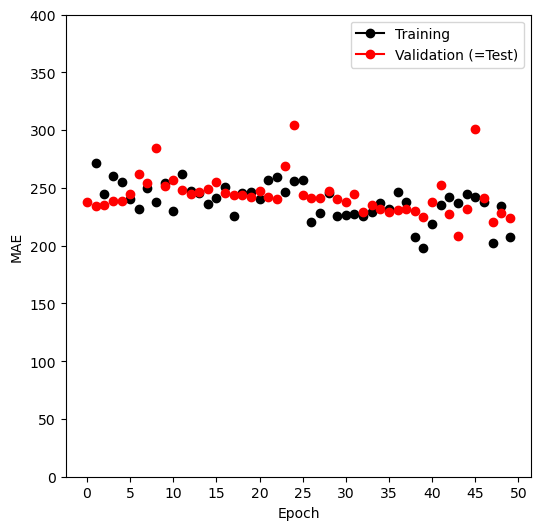

In [26]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

def summary_plot(results, ax, col="loss", valid_legend="Validation", training_legend="Training", ylabel="Loss", fontsize =20):
    for (column, color, label) in zip([f"train_{col}_epoch", f"valid_{col}"], ["black", "red"], [training_legend, valid_legend ]):
        results.plot(x="epoch", y=column, label=label, marker="o", color=color, ax=ax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    return ax

fig, ax = subplots (1, 1, figsize =(6, 6))
ax = summary_plot(hit_results, ax, col="mae", ylabel="MAE", valid_legend="Validation (=Test)")
ax.set_ylim ([0, 400])
ax.set_xticks(np.linspace (0, 50, 11).astype(int));

In [27]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(224.2696, grad_fn=<MeanBackward0>)

In [28]:
del(Hitters, hit_model, hit_dm, hit_logger, hit_test, hit_train, X, Y, X_test, X_train, Y_test, Y_train, X_test_t,  Y_test_t, hit_trainer, hit_module)

Multilayer Network on the MNIST Digit Data

In [29]:
(mnist_train, mnist_test) = [MNIST(root="data", train=train, download=True, transform=ToTensor ())
for train in [True , False ]]
mnist_train

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 4769777.29it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4640709.37it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4557542.77it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [31]:
mnist_dm = SimpleDataModule(mnist_train, mnist_test, validation =0.2, num_workers=max_num_workers, batch_size =256)

for idx , (X_ ,Y_) in enumerate(mnist_dm.train_dataloader ()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [33]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel , self).__init__()
        self.layer1 = nn.Sequential( nn.Flatten(), nn.Linear (28*28 , 256), nn.ReLU(), nn.Dropout (0.4))
        self.layer2 = nn.Sequential(nn.Linear (256, 128),nn.ReLU(), nn.Dropout (0.3))
        self._forward = nn.Sequential( self.layer1, self.layer2, nn.Linear (128, 10))
    def forward(self , x):
        return self._forward(x)
    
mnist_model = MNISTModel()

mnist_model(X_).size()

torch.Size([256, 10])

In [34]:
summary(mnist_model, input_data=X_, col_names =["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     